In [25]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer
import boulderopal as bo
import qutip as qt
import scipy.special as sp
import qctrlvisualizer as qv
import jsonpickle



In [26]:
def pulses_der(x, paras,total_time,angle,anh):
    control = -2*np.pi/total_time*(paras[0]-angle/2)*np.sin(2*np.pi/total_time*x)
    for i in range(len(paras)):
        if i==len(paras)-1:
            control += -2*(i+2)*np.pi/total_time*(-paras[i])*np.sin(2*(i+2)*np.pi/total_time*x)
        else:
            control += -2*(i+2)*np.pi/total_time*(paras[i+1]-paras[i])*np.sin(2*(i+2)*np.pi/total_time*x)
    return -control/(2*anh)/total_time
# initial guess for x-quadrature control
def pulses(x, paras,total_time,angle):
    control = angle/2 + (paras[0]-angle/2)*np.cos(2*np.pi/total_time*x)
    for i in range(len(paras)):
        if i==len(paras)-1:
            control += (-paras[i])*np.cos(2*(i+2)*np.pi/total_time*x)
        else:
            control += (paras[i+1]-paras[i])*np.cos(2*(i+2)*np.pi/total_time*x)
    return control/total_time
from itertools import product
def initial_list(segment_count, duration, anh, angle, alpha_max):
    # Define the range for a, b, c
    parameter_range = np.arange(-6, 8, 2)
    times = np.linspace(0, duration, segment_count)

    # Generate all combinations of a, b, c
    parameter_combinations = list(product(parameter_range, repeat=3))

    # Initialize lists to store I_initials and Q_initials for each combination
    I_initials_list = []
    Q_initials_list = []

    # Helper function to cap absolute values at alpha_max
    def cap_amplitude(arr, max_val):
        return np.clip(arr, -max_val, max_val)

    # Generate I_initials and Q_initials for each combination
    for a, b, c in parameter_combinations:
        I_initials = pulses(times, (a, b, c), duration, angle)
        Q_initials = pulses_der(times, (a, b, c), duration, angle, anh)
        
        # Cap the amplitudes at alpha_max
        I_initials_capped = cap_amplitude(I_initials, alpha_max)
        Q_initials_capped = cap_amplitude(Q_initials, alpha_max)
        
        I_initials_list.append(I_initials_capped)
        Q_initials_list.append(Q_initials_capped)


    return I_initials_list, Q_initials_list

In [27]:
bo.cloud.authenticate(api_key="L22oSBrX9bNTV7xvghbrMbI7JJeSTnI0u0gEolBYzrrJxhLOfu")

Q-CTRL authentication successful!


In [28]:
graph = bo.Graph()

In [29]:
# Pulse parameters.
#pulse amplitude constraint
alpha_max = 2*np.pi* 15e6  # rad/s
#np.pi/2 is pi/2 gate, np.pi would be pi gate
angle = np.pi

anh = -2 * np.pi * 245.3844e6
segment_count = 40
duration = segment_count * 1e-9  # s
I_initials,Q_initials = initial_list(segment_count, duration, anh, angle,alpha_max)

In [30]:
envelope_signal = graph.signals.cosine_pulse_pwc(
    duration=duration, segment_count=segment_count, amplitude=1.0,flat_duration=0.9 * duration,
)

# Real PWC signal representing α(t).
I = graph.real_optimizable_pwc_signal(
    segment_count=segment_count,
    duration=duration,
    minimum=-alpha_max,
    maximum=alpha_max,
    initial_values= I_initials,
    name="$\\I$",
)
RI = graph.filter_and_resample_pwc(
    pwc=I,
    kernel=graph.sinc_convolution_kernel(5/duration*2*np.pi),
    segment_count=segment_count,
    name="$L(\\I)$",
)
ORI = envelope_signal*RI
ORI.name = "$\\Omega L(\\I)$"

Q = graph.real_optimizable_pwc_signal(
    segment_count=segment_count,
    duration=duration,
    minimum=-alpha_max,
    maximum=alpha_max,
    initial_values= Q_initials,
    name="$\\Q$",
)
RQ = graph.filter_and_resample_pwc(
    pwc=Q,
    kernel=graph.sinc_convolution_kernel(10/duration*2*np.pi),
    segment_count=segment_count,
    name="$L(\\Q)$",
)
ORQ = envelope_signal*RQ
ORQ.name = "$\\Omega L(\\Q)$"

In [31]:
dim = 5
N_q = 5
a_q = qt.destroy(N_q)
n_q = a_q.dag() * a_q
H0 =  1/2*anh* a_q.dag()**2 * a_q**2
Hcx=a_q+a_q.dag()
Hcy=-a_q*1j+1j*a_q.dag()
H0=H0.full()
Hcx=Hcx.full()
Hcy=Hcy.full()
detuning = 0.01*2*np.pi*1e9
dephasing = detuning*a_q.dag()*a_q
dephasing = dephasing.full()
# Total Hamiltonian.
hamiltonian = H0+ORI*Hcx+ORQ*Hcy

In [32]:
import numpy as np
def Rx(matrix,angle):
    matrix[0,0]=np.cos(angle/2)
    matrix[0,1]=-1j*np.sin(angle/2)
    matrix[1,0]=-1j*np.sin(angle/2)
    matrix[1,1]=np.cos(angle/2)
    return matrix
targets=np.zeros([dim ,dim ],dtype=complex)
targets=Rx(targets,angle)
#specify subspace fidelity
qubit_projector = np.pad(np.eye(2), ((0, 3), (0, 3)), mode="constant")
target_operator = graph.target(
    targets, filter_function_projector=qubit_projector
)


In [33]:
infidelity = graph.infidelity_pwc(
    hamiltonian=hamiltonian,
    target=target_operator,
    name="infidelity",
)
robust_infidelity = graph.infidelity_pwc(
    hamiltonian=hamiltonian,
    noise_operators=[np.array(dephasing)],
    target=target_operator,
    name="robust_infidelity",
)

In [34]:
optimization_result = bo.run_optimization(
    cost_node_name="robust_infidelity",
    output_node_names=["$\\I$", "$\\Q$","$L(\\I)$", "$L(\\Q)$","$\\Omega L(\\I)$","$\\Omega L(\\Q)$",],
    graph=graph,
    optimization_count=7**3,
)

print(f"\nOptimized cost:\t{optimization_result['cost']:.3e}")

Your task (action_id="2051021") has started.
Your task (action_id="2051021") has completed.

Optimized cost:	3.522e-07


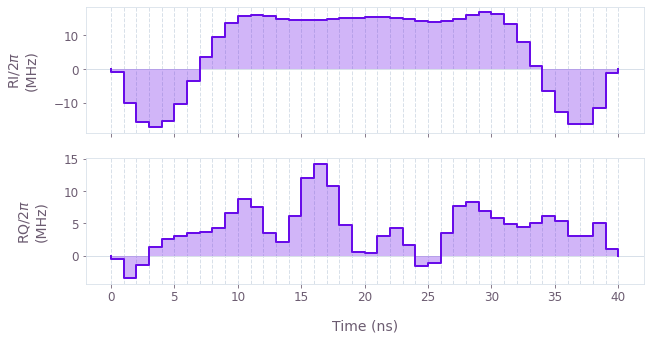

In [35]:

qv.plot_controls(
    {
        "RI": optimization_result["output"]["$\\Omega L(\\I)$"],
        "RQ": optimization_result["output"]["$\\Omega L(\\Q)$"],
    },
    polar=False,
)

In [36]:
def save_variable(file_name, var):
    """
    Save a single variable to a file using jsonpickle.
    """
    with open(file_name, "w") as file:
        encoded_var = jsonpickle.encode(var, unpicklable=True)
        file.write(encoded_var)


def load_variable(file_name):
    """
    Load a variable from a file encoded with jsonpickle.
    """
    with open(file_name, "r") as file:
        decoded_var = jsonpickle.decode(file.read())
        return decoded_var

In [37]:
import os
resources_path = os.path.normpath(os.path.join(os.getcwd(), "./"))

In [38]:
from datetime import datetime

fname = "pi_60ns_" + datetime.now().strftime("%Y%m%d")
save_variable(resources_path+"/"+fname, optimization_result)